In [1]:
import sys

sys.path.append('/kaggle/input/alexnet2/pytorch/default/1')

import torch

import torch.nn as nn

from torchvision import datasets

import torchvision

from improved.pca import pca

from improved.data_transforms import calc_mean_std, prepreprocess, get_preprocess, get_train_augment

from improved.train import train

import matplotlib.pyplot as plt

from improved.eval import top1_k 

In [2]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
train_dataset = datasets.Imagenette(

    'datasets/imagenette', split='train', size='320px', download=True, transform=prepreprocess)

mean, std = calc_mean_std(train_dataset)

print(f'Mean:\n{mean}')

print(f'Standard Deviation:\n{std}')

preprocess = get_preprocess(mean, std)



train_dataset = datasets.Imagenette(

    'datasets/imagenette', split='train', size='320px', transform=preprocess)

eigvals, eigvecs = pca(train_dataset)

train_augment = get_train_augment(eigvals, eigvecs, mean, std)



train_dataset = datasets.Imagenette(

    'datasets/imagenette', split='train', size='320px', transform=train_augment)



val_dataset = datasets.Imagenette(

    'datasets/imagenette', split='val', size='320px',transform=preprocess)

val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])



print(f'Train: {len(train_dataset)}')

print(f'Validation: {len(val_dataset)}')

print(f'Test: {len(test_dataset)}')

100%|██████████| 341663724/341663724 [00:07<00:00, 45734642.85it/s]


Extracting datasets/imagenette/imagenette2-320.tgz to datasets/imagenette
Mean:
[0.4666706919670105, 0.45878785848617554, 0.43017029762268066]
Standard Deviation:
[0.28003814816474915, 0.27618539333343506, 0.2980325520038605]
Covar:
tensor([[0.9999, 0.9060, 0.7768],
        [0.9060, 0.9999, 0.9098],
        [0.7768, 0.9098, 1.0001]], device='cuda:0')
Eigen values (sqrt):
tensor([[0.2165],
        [0.4725],
        [1.6522]])
Eigen vectors:
tensor([[ 0.4129,  0.7125,  0.5673],
        [-0.8029, -0.0092,  0.5960],
        [ 0.4299, -0.7016,  0.5683]])
Train: 9469
Validation: 1963
Test: 1962


In [4]:
model = torchvision.models.resnet50(weights=None, num_classes=len(train_dataset.classes))

if torch.cuda.device_count() > 1:

    print(f'Using {torch.cuda.device_count()} GPUs.')

    model = nn.DataParallel(model)

model.to(device)

# initialize parameters

# init_params(model)

compiled_model = model

# if torch.cuda.is_available():

#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(

    compiled_model,

    train_dataset=train_dataset,

    cv_dataset=val_dataset,

    batch_size=128,

    num_epochs=200,

    initial_lr=0.01,

    num_workers=3,

    patience=20,

)

Epoch 1/200, Cost: 3.011, Val Error: 84.56%, lr: 0.01, Time: 80s
Epoch 2/200, Cost: 2.247, Val Error: 76.06%, lr: 0.01, Time: 79s
Epoch 3/200, Cost: 2.071, Val Error: 62.91%, lr: 0.01, Time: 78s
Epoch 4/200, Cost: 1.918, Val Error: 60.47%, lr: 0.01, Time: 78s
Epoch 5/200, Cost: 1.791, Val Error: 51.35%, lr: 0.01, Time: 78s
Epoch 6/200, Cost: 1.652, Val Error: 44.93%, lr: 0.01, Time: 79s
Epoch 7/200, Cost: 1.564, Val Error: 40.19%, lr: 0.01, Time: 79s
Epoch 8/200, Cost: 1.470, Val Error: 37.04%, lr: 0.01, Time: 78s
Epoch 9/200, Cost: 1.410, Val Error: 39.84%, lr: 0.01, Time: 79s
Epoch 10/200, Cost: 1.330, Val Error: 32.71%, lr: 0.01, Time: 79s
Epoch 11/200, Cost: 1.257, Val Error: 32.20%, lr: 0.01, Time: 79s
Epoch 12/200, Cost: 1.184, Val Error: 31.02%, lr: 0.01, Time: 79s
Epoch 13/200, Cost: 1.152, Val Error: 27.61%, lr: 0.01, Time: 79s
Epoch 14/200, Cost: 1.120, Val Error: 30.77%, lr: 0.01, Time: 79s
Epoch 15/200, Cost: 1.093, Val Error: 28.17%, lr: 0.01, Time: 79s
Epoch 16/200, Cost:

In [6]:
# torch.save(model.state_dict(), 'improved_imagenette.model.pt')

# torch.save(preprocess, 'improved_imagenette.preprocess.pt')

# torch.save(train_augment, 'improved_imagenette.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)

print(f'Test Top 1: {test_top1}')

print(f'Test Top 5: {test_top5}')



val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)

print(f'Val Top 1: {val_top1}')

print(f'Val Top 5: {val_top5}')



train_eval_dataset = datasets.Imagenette(

    'datasets/imagenette', split='train', size='320px', transform=preprocess)

train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)

print(f'Train Top 1: {train_top1}')

print(f'Train Top 5: {train_top5}')

Test Top 1: 0.9225280326197758
Test Top 5: 0.9933741080530072
Val Top 1: 0.9271523178807947
Val Top 5: 0.9918492103922567
Train Top 1: 1.0
Train Top 5: 1.0


Text(0.5, 1.0, 'Costs')

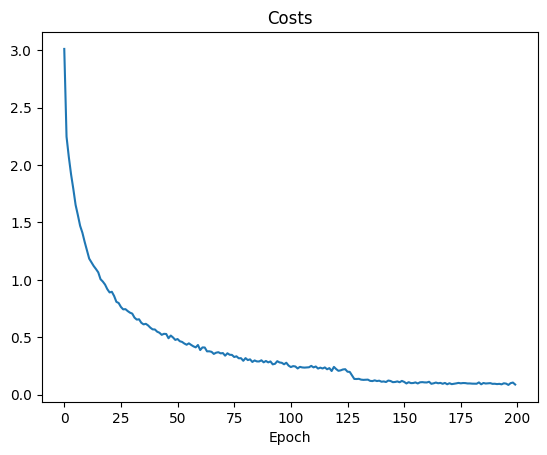

In [8]:
plt.plot(costs)

plt.xlabel("Epoch")

plt.title('Costs')

Text(0.5, 1.0, 'Validation Error Rates')

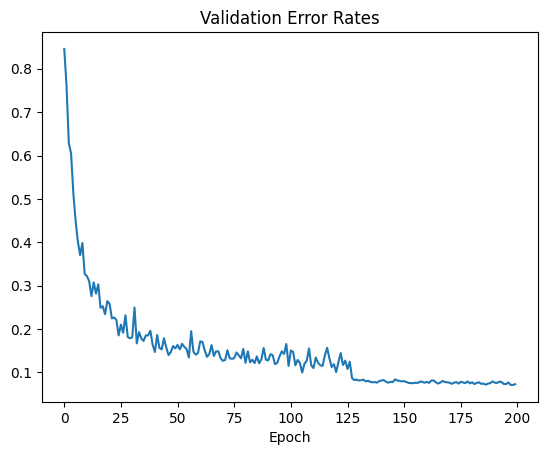

In [9]:
plt.plot(val_error_rates)

plt.xlabel("Epoch")

plt.title('Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

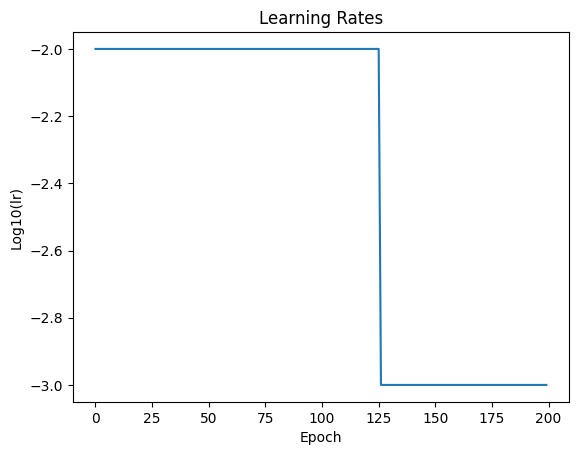

In [10]:
import math



plt.plot([math.log10(lr) for lr in learning_rates])

plt.ylabel("Log10(lr)")

plt.xlabel("Epoch")

plt.title('Learning Rates')